# Factor Investing
Traditional forms of investing would be either passive or active. Passive involved putting money in an index and getting returns based on that. Active investing meant trying to outperform the market and it is very difficult to do so as managers need 'skill' i.e alpha should be positive.<br>
Factor investing is a new form of investing which aims at targetting quantifiable firm characteristics such as value, size and momentum. A factor is a variable that influences the return of assets. Exposing firms to such factors will generate good results in the future, for instance, a portfolio of stocks exposed to the 'Value' factor will generally outperform the growth stocks; and Small Cap stocks perform better than Large Cap stocks in the long term.<br>
I will be doing a factor analysis on Berkshire Hathaway stock from 2000 until 2020. Data is from Yahoo website and the factor data is from the Ken French website.

In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# function to get compound growth
def compound(r):
    return np.exp(np.log(1+r).sum()) - 1

In [24]:
# Analyze Berkshire Hathaway stock. Convert daily stock prices into daily returns, and then into monthly returns.
tickers = ['BRK-B']
brka_p = pd.DataFrame()
for t in tickers:
    brka_p[t] = wb.DataReader(t, data_source = 'yahoo', start = '1990-7-2')['Adj Close']

brka_dr = brka_p.pct_change() 
brka_mr = brka_dr.resample('M').apply(compound).to_period('M')
brka_mr.head()

,BRK-B
Date,
1996-05,-0.120690
1996-06,0.012745
1996-07,-0.006776
1996-08,0.014620
1996-09,0.030740


In [85]:
# Fama-French data on Excess Market, Value and Size factors
def ffr():
    returns = pd.read_csv("F-F_Research_Data_Factors.csv", 
                     header = 0, index_col = 0, parse_dates = True, na_values=-99.99)/100
    returns.index = pd.to_datetime(returns.index, format = '%Y%m').to_period('M')
    return returns
ffr=ffr()
ffr.tail()

,Mkt-RF,SMB,HML,RF
2019-12,0.0277,0.0068,0.0183,0.0014
2020-01,-0.0011,-0.0311,-0.0627,0.0013
2020-02,-0.0813,0.0096,-0.0401,0.0012
2020-03,-0.1339,-0.0516,-0.1412,0.0012
2020-04,0.1365,0.0280,-0.0125,0.0000


In [41]:
# Regression 1: This is the CAPM model to see how the market drives Berkshire stock
# Results: For each dollar invested, Berkshire puts 47 cents in the market and 53 cents in treasury bills
# The result is also significant since p-value < 10% if we are testing at a 10% level of significance
# Alpha is 0.52% per month which is a considerable amount.

brka_excess = brka_mr["2000-01":"2020-01"] - ffr.loc["2000-01":"2020-01",["RF"]].values
mkt_excess = ffr.loc["2000-01":"2020-01",["Mkt-RF"]]
expl_variables = mkt_excess.copy()
expl_variables["Alpha"] = 1
lm = sm.OLS(brka_excess, expl_variables).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  BRK-B   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     49.22
Date:                Fri, 29 May 2020   Prob (F-statistic):           2.34e-11
Time:                        21:55:51   Log-Likelihood:                 405.03
No. Observations:                 241   AIC:                            -806.1
Df Residuals:                     239   BIC:                            -799.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.4727      0.067      7.016      0.000       0.340       0.605
Alpha          0.0052      0.003      1.771      0.078      -0.001       0.011
==============================================================================
Omnibus:                       56.235   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.562
Skew:                           0.962   Prob(JB):                     1.02e-39
Kurtosis:                       6.766   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
expl_variables["Size"] = ffr.loc["2000-01":"2020-01",["SMB"]]
expl_variables["Value"] = ffr.loc["2000-01":"2020-01",["HML"]]
expl_variables.head()

,Mkt-RF,Alpha,Size,Value
2000-01,-0.0474,1,0.0495,-0.0028
2000-02,0.0245,1,0.2170,-0.0993
2000-03,0.0520,1,-0.1687,0.0737
2000-04,-0.0640,1,-0.0772,0.0861
2000-05,-0.0442,1,-0.0511,0.0257


In [43]:
# Regression 2: This is the Fama-French model to see how Value, Size and the Market drive Berkshire stock
# Results: For each dollar invested, Berkshire puts 57 cents in the market and 43 cents in treasury bills.
# Adding these 2 variables has increased the coefficient of Mkt-RF.
# Value is positive so they go 46 cents long on Value stocks and 46 cents short on Growth stocks
# Size is negative so they go 45 cents long on Large Cap stocks and 45 cents short on Small/Medium Cap stocks.
# p-values are under 10% so the results are significant. This shows they are Large Value investors.
# Alpha is still positive so they deifinitely have 'skill'
# R^2 which explains how much variation in Y is explained by the model, is low at 38%. This would increase if we added extra relevant explanatory variables

lm = sm.OLS(brka_excess, expl_variables).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  BRK-B   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     48.35
Date:                Fri, 29 May 2020   Prob (F-statistic):           2.03e-24
Time:                        22:01:21   Log-Likelihood:                 440.01
No. Observations:                 241   AIC:                            -872.0
Df Residuals:                     237   BIC:                            -858.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5797      0.061      9.557      0.000       0.460       0.699
Alpha          0.0048      0.003      1.863      0.064      -0.000       0.010
Size          -0.4525      0.083     -5.448      0.000      -0.616      -0.289
Value          0.4671      0.082      5.668      0.000       0.305       0.629
==============================================================================
Omnibus:                       56.041   Durbin-Watson:                   2.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.200
Skew:                           1.083   Prob(JB):                     5.34e-29
Kurtosis:                       5.876   Cond. No.                         36.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Cap-Weighted Indices vs Equally-Weighted Indices

Default approach is to usually use a cap-weighted index (eg S&P500) as a benchmark for active or passive managers. It is, however, an inefficient portfolio as it lies way inside the efficient frontier. They tend to be heavily concentrated and poorly diversified. For instance, the S&P500's largest 10 stocks make up a large proportion of the S&P500 so if they are affected, then the entire index will be effected.<br>
To solve the problem, smart-weighted benchmarks have been introduced such as Equally-Weighted, Minimum Variance and Rsik Parity benchmarks.<br>
To work with Smart-Weighted benchmarks, we first need to select the desired factor exposure such as Value, Size or Momentum. Then we would select one of those 3 Smart-Weighted benchmarks.<br>
As an example, I compare below the Sharpe Ratios of an Equally-Weighted index vs a Cap-Weighted Index to show that the latter is indeed inefficient.

In [83]:
ind_30_ew = pd.read_csv("industry_30_ew.csv", 
                     header = 0, index_col = 0, parse_dates = True, na_values=-99.99)/100
ind_30_ew.index = pd.to_datetime(ind_30_ew.index, format = '%Y%m').to_period('M')
ind_30_ew.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2019-12,0.0275,0.0070,0.0329,0.0271,0.0337,0.0271,0.0495,0.0966,0.0271,-0.0813,...,0.0367,0.0125,0.0597,0.0138,0.0163,0.0467,0.0193,0.0084,0.0252,0.0566
2020-01,-0.0283,-0.0077,-0.0924,0.0046,-0.0593,-0.0302,-0.0719,0.0426,-0.0772,-0.0103,...,-0.0082,0.0166,-0.0061,-0.0033,-0.0494,-0.0507,-0.0718,0.0041,-0.0358,0.0144
2020-02,-0.0766,-0.0805,-0.0053,-0.1226,-0.1079,-0.1104,-0.1230,-0.0081,-0.1311,-0.1306,...,-0.0463,-0.0720,-0.0822,-0.1045,-0.1120,-0.0768,-0.0917,-0.0882,-0.0846,-0.0511
2020-03,-0.0617,-0.1722,-0.1022,-0.3285,-0.2820,-0.2500,-0.3250,-0.1728,-0.2287,-0.3254,...,-0.2354,-0.2157,-0.1802,-0.2314,-0.2291,-0.2169,-0.2346,-0.3951,-0.2329,-0.2225
2020-04,0.0981,0.2239,0.0471,0.2973,0.1192,0.1867,0.1550,0.2168,0.1795,0.0726,...,0.1042,0.1896,0.2237,0.1859,0.1272,0.1444,0.2603,0.3283,0.0907,0.1598


In [84]:
ind_30_cw = pd.read_csv("30_Industry_Portfolios_cw.csv", 
                     header = 0, index_col = 0, parse_dates = True, na_values=-99.99)/100
ind_30_cw.index = pd.to_datetime(ind_30_cw.index, format = '%Y%m').to_period('M')
ind_30_cw.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2019-12,0.0358,0.0138,0.0322,0.0397,0.0323,0.0265,0.0768,0.0333,0.0135,-0.0342,...,0.0123,0.0179,0.0624,0.0217,-0.0024,0.0239,0.0121,0.0259,0.0260,0.0205
2020-01,0.0093,0.0266,-0.0366,0.0027,-0.0473,0.0043,-0.0540,-0.0181,-0.0904,-0.0458,...,-0.0208,0.0482,0.0081,-0.0472,-0.0048,-0.0290,0.0117,0.0091,-0.0225,0.0091
2020-02,-0.0883,-0.0743,-0.0671,-0.0505,-0.0661,-0.0848,-0.0936,-0.0563,-0.1012,-0.0816,...,-0.0594,-0.0555,-0.0916,-0.0738,-0.1096,-0.0938,-0.0616,-0.0902,-0.1060,-0.0857
2020-03,-0.0873,-0.0988,-0.0675,-0.1642,-0.2308,-0.0684,-0.1853,-0.0531,-0.1837,-0.3596,...,-0.1339,-0.1152,-0.0880,-0.0976,-0.1647,-0.1786,-0.0443,-0.2167,-0.2003,-0.1346
2020-04,0.0717,0.1101,0.0197,0.1517,0.0894,0.1032,0.1057,0.1300,0.1843,0.1315,...,0.0964,0.1611,0.1396,0.0973,0.0852,0.1268,0.1864,0.1843,0.1171,0.0398


In [61]:
#Sharpe Ratio is the ratio of excess return to volatility.
def ann_ret(ret):
    compound_r = (1+ret).prod()
    num_periods = ret.shape[0]
    return compound_r**(12/num_periods) - 1

def ann_vol(ret):
    return ret.std() * np.sqrt(12)

def sharpe_ratio(ret, riskfree_a):
    riskfree_m = (1+riskfree_a)**(1/12) - 1
    excess_r = ret - riskfree_m
    ann_excess_r = ann_ret(excess_r)
    ann_volatility = ann_vol(ret)
    return ann_excess_r/ann_volatility

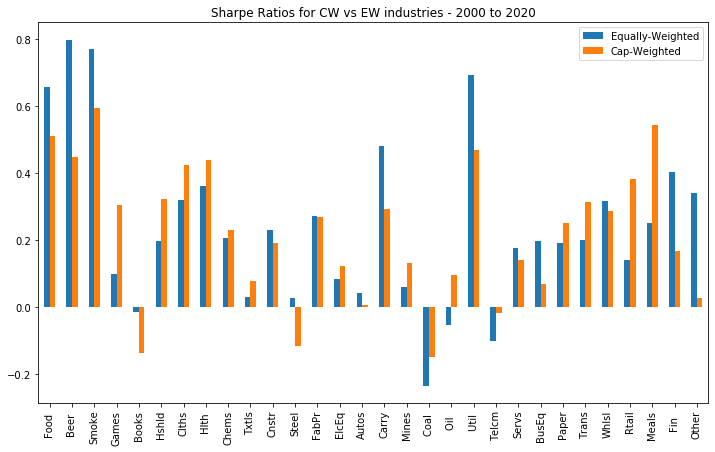

In [81]:
# Based on this example, we see that 50% of the equally-weighted industries have a larger sharpe-ratio than their cap-weighted counterparts for the last 20 years.
# Equally-weighted portfolios are more diversified and may, therefore, carry less risk. 
# It also focuses on value investing, which outperforms growth in the long term.

comparison = pd.DataFrame({"Equally-Weighted": sharpe_ratio(ind_30_ew["2000":], 0.02),
             "Cap-Weighted": sharpe_ratio(ind_30_cw["2000":], 0.02)})
comparison.plot.bar(legend = True, title = 'Sharpe Ratios for CW vs EW industries - 2000 to 2020', figsize = (12,7))

In [82]:
(comparison["Equally-Weighted"] > comparison["Cap-Weighted"]).sum()

15